In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score
import xgboost as xgb
from collections import Counter
import pickle
import sklearn

In [9]:
df = pd.read_excel("PCOS_data_without_infertility.xlsx")

In [10]:
df

,Sl. No,Patient File No.,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),...,Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm),Unnamed: 44
0,1,1,0,28,44.6,152.000,19.3,15,78,22,...,1.0,0,110,80,3,3,18.0,18.0,8.5,NaN
1,2,2,0,36,65.0,161.500,NaN,15,74,20,...,0.0,0,120,70,3,5,15.0,14.0,3.7,NaN
2,3,3,1,33,68.8,165.000,NaN,11,72,18,...,1.0,0,120,80,13,15,18.0,20.0,10.0,NaN
3,4,4,0,37,65.0,148.000,NaN,13,72,20,...,0.0,0,120,70,2,2,15.0,14.0,7.5,NaN
4,5,5,0,25,52.0,161.000,NaN,11,72,18,...,0.0,0,120,80,3,4,16.0,14.0,7.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536,537,537,0,35,50.0,164.592,18.5,17,72,16,...,0.0,0,110,70,1,0,17.5,10.0,6.7,NaN
537,538,538,0,30,63.2,158.000,25.3,15,72,18,...,0.0,0,110,70,9,7,19.0,18.0,8.2,NaN
538,539,539,0,36,54.0,152.000,23.4,13,74,20,...,0.0,0,110,80,1,0,18.0,9.0,7.3,NaN
539,540,540,0,27,50.0,150.000,22.2,15,74,20,...,0.0,0,110,70,7,6,18.0,16.0,11.5,NaN


In [20]:
df.columns

Index(['Sl. No', 'Patient File No.', 'PCOS (Y/N)', ' Age (yrs)', 'Weight (Kg)',
       'Height(Cm) ', 'BMI', 'Blood Group', 'Pulse rate(bpm) ',
       'RR (breaths/min)', 'Hb(g/dl)', 'Cycle(R/I)', 'Cycle length(days)',
       'Marraige Status (Yrs)', 'Pregnant(Y/N)', 'No. of aborptions',
       '  I   beta-HCG(mIU/mL)', 'II    beta-HCG(mIU/mL)', 'FSH(mIU/mL)',
       'LH(mIU/mL)', 'FSH/LH', 'Hip(inch)', 'Waist(inch)', 'Waist:Hip Ratio',
       'TSH (mIU/L)', 'AMH(ng/mL)', 'PRL(ng/mL)', 'Vit D3 (ng/mL)',
       'PRG(ng/mL)', 'RBS(mg/dl)', 'Weight gain(Y/N)', 'hair growth(Y/N)',
       'Skin darkening (Y/N)', 'Hair loss(Y/N)', 'Pimples(Y/N)',
       'Fast food (Y/N)', 'Reg.Exercise(Y/N)', 'BP _Systolic (mmHg)',
       'BP _Diastolic (mmHg)', 'Follicle No. (L)', 'Follicle No. (R)',
       'Avg. F size (L) (mm)', 'Avg. F size (R) (mm)', 'Endometrium (mm)'],
      dtype='object')

In [15]:
df = df.drop(['Unnamed: 44'], axis=1)

In [22]:
df['BMI'] = df['Weight (Kg)'] / (df['Height(Cm) '] / 100) ** 2

In [25]:
df = df.drop(['FSH/LH'], axis=1)

In [27]:
df['Waist:Hip Ratio'] = df['Waist(inch)']/df['Hip(inch)']

In [29]:
df.dropna(inplace=True)

In [61]:
df['II    beta-HCG(mIU/mL)'] = pd.to_numeric(df['II    beta-HCG(mIU/mL)'], errors='coerce')
df['AMH(ng/mL)'] = pd.to_numeric(df['AMH(ng/mL)'], errors='coerce')

In [62]:
y = df['PCOS (Y/N)']
X = df.drop(columns=['PCOS (Y/N)'])

In [63]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [74]:
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_params_list = []
outer_scores = []

In [75]:
for train_idx, test_idx in outer_cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # inner cross validation does hyperparamter tuning
    xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=0)
    grid_search.fit(X_train, y_train)
    
    # store the best hyperparameters
    best_params_list.append(frozenset(grid_search.best_params_.items()))
    
    # evaluate best model on outer test set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    outer_scores.append(accuracy)
    
    print(f"Fold Accuracy: {accuracy:.4f}")

Fold Accuracy: 0.9352
Fold Accuracy: 0.8889
Fold Accuracy: 0.9074
Fold Accuracy: 0.9352
Fold Accuracy: 0.8505


In [77]:
#determine most frequent best hyperparameters
most_common_params = dict(Counter(best_params_list).most_common(1)[0][0])
print("Most Common Hyperparameters:", most_common_params)

Most Common Hyperparameters: {'max_depth': 3, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.1, 'n_estimators': 500}


In [78]:
#train final model on full dataset
final_model = xgb.XGBClassifier(**most_common_params, use_label_encoder=False, eval_metric='logloss')
final_model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

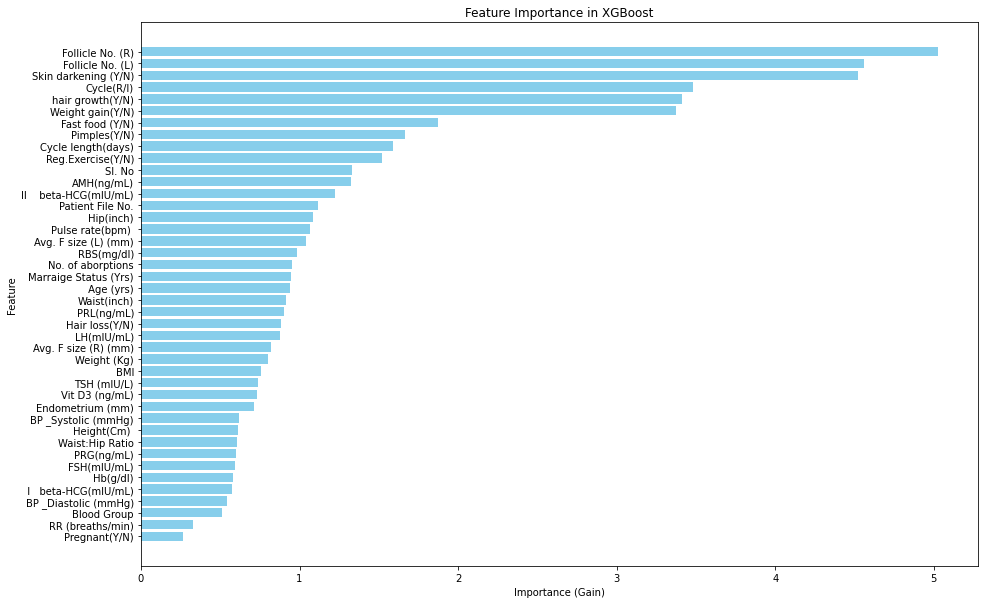

In [93]:
feature_importance = final_model.get_booster().get_score(importance_type='gain')

importance_df = pd.DataFrame(feature_importance.items(), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(15, 10))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel("Importance (Gain)")
plt.ylabel("Feature")
plt.title("Feature Importance in XGBoost")
plt.gca().invert_yaxis() 
plt.show()


In [81]:
#save final model
with open('best_xgboost_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

print("Final model trained and saved!")

Final model trained and saved!


In [90]:
print(f"NumPy Version: {np.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Scikit-learn Version: {sklearn.__version__}")
print(f"XGBoost Version: {xgb.__version__}")

NumPy Version: 1.24.4
Pandas Version: 2.0.3
Scikit-learn Version: 1.3.2
XGBoost Version: 2.0.0
